# Caso de uso:  Implementación de mallado adaptativo para el Método de Elementos Finitos para la ecuación de Poisson en una dimensión.
### Nicolás Núñez

## Ecuación de Poisson en una dimensión

La ecuación de Poisson es una ecuación diferencial parcial de segundo orden ampliamente utilizada en física y matemáticas dada por
$$ \Delta \varphi\,=\, \mathbf{f}$$
donde $\Delta$ es el operador de Laplace, y $\mathbf{f}$ y $\varphi$ son funciones reales o de valores complejos en una variedad. Si la variedad es el espacio euclidiano el Laplaciano se puede representar por $\nabla ^2$, donde $\nabla$ representa el gradiente (Para más información visitar [esta página](https://en.wikipedia.org/wiki/Poisson%27s_equation)).



## Caso unidimensional con condiciones de Dirichlet

Si consideramos el problema de valores de contorno unidimensional con condiciones de Dirichlet, la ecuación de Poisson se expresa como

$$-\dfrac{\partial^2}{\partial x^2}u\,=\,f\qquad ,\forall x\in (a,b)$$

con $u(a) = u_0$ y $u(b)=u_2$.

La solución a la ecuación anterior es posible aproximarla con el Método de Elementos Finitos (vease este [link](https://en.wikipedia.org/wiki/Finite_element_method)). Para lo cual se deriva su formulación debil al testear respecto a una función lo suficientemente suave e integrando por partes, con lo que se obtiene el problema: Hallar $u$ tal que:

$$ \int_a^b u'v' - vu'\Big\vert_a^b = \int_a^b fv $$




## Discretización y Método de Galerkin

Para nuestro caso de uso, realizaremos la implementación de la aproximación con polinomios de grado uno por tramos, para esto consideramos una partición de [a,b] de la forma

$$a = x_0 < x_1 < ... < x_{n-1} < x_n = b$$

sobre la cual definimos el espacio de funciones continuas sobre la partición anterior, esto es
$$ P_h \,:=\, \left\lbrace f\in \mathcal{C}([a,b]): f\vert_{[x_i,x_{i+1}]}\in \mathbb{P}_1([a,b]), \forall i\in \lbrace 0, n-1\rbrace\right\rbrace$$

Si consideramos una base $\{\varphi_i\}_{i=0}^n$ de $P_h$ de modo que

$$ \varphi_i(x_j) = \delta_{ij} \qquad \forall i, j \in \lbrace 0,1,..., n\rbrace $$

las cuales se definen por

$$ \varphi_{i}(x) = \begin{cases}
\dfrac{x-x_{i_1}}{x_i-x_{i-1}} & \text{si } x \in [x_{i-1},x_{i}] \\
\dfrac{x_{i+1}-x}{x_{i+1}-x_{i}} & \text{si } x \in [x_{i},x_{i+1}] \\
0 & \text{en otro caso}
\end{cases}  $$
es posible construir el esquema de Galerkin (ver [aquí](https://en.wikipedia.org/wiki/Galerkin_method)) asociado a la ecuación original dado por: Hallar $u_h\in P_h$ tal que

$$ \int_a^b u_h'v_h' - v_hu_h'\Big\vert_a^b = \int_a^b fv_h \qquad\forall v_h\in P_h.$$

De lo anterior, dado que $u_h \in P_h$ entonces existen escalares $\lbrace u_i\rbrace_{i=0}^n\subset \mathbb{R}$ tal que

$$u_h = \sum_{i=0}^n u_i\varphi_i(x)$$

y considerando que la ecuación discreta es posible expresarla a través de las funciones base del espacio discreto escogido, las cuales tienen soporte solo en elementos continuos, es posible reescribir la formulación discreta como el esquema de Galerkin asociado

$$\sum_{i=j-1}^{j+1} u_i \int_{x_{j-1}}^{x_{j+1}} \varphi_{i}'\varphi_{j}' = \int_{a}^b f\varphi_j \qquad \forall j\in\lbrace 1, ...,n+1\rbrace$$

Así, dado que $\varphi_i\in\mathbb{P}_1$, y por lo tanto, $\varphi_i'\in\mathbb{P}_0$ para todo $i$, es más
$$ \varphi_{i}'(x) = \begin{cases}
\dfrac{1}{x_i-x_{i-1}} & \text{si } x \in [x_{i-1},x_{i}] \\
\dfrac{-1}{x_{i+1}-x_{i}} & \text{si } x \in [x_{i},x_{i+1}] \\
0 & \text{en otro caso}
\end{cases}  $$

es fácil ver que la matriz que representa el sistema de ecuaciones asociado al esquema de Galerkin es tridiagonal con elementos $(a_{ij})_{i,j=1}^{n-1}$ tales que
$$ a_{ij} = \begin{cases}
\dfrac{-1}{x_i-x_{i-1}} & \text{si } i>j \\
\dfrac{-1}{x_i-x_{i-1}} +  \dfrac{-1}{x_{i+1}-x_{i}} & \text{si } i=j \\
\dfrac{-1}{x_{i+1}-x_{i}} & \text{si } i<j
\end{cases}  $$
y lado derecho $(b_i = \int_{a}^b f\varphi_j)_{i=1}^{n-1}$ más las condiciones de contorno Dirichlet en su primer y último elemento. Es importante comentar que estos términos se aproximaran con una regla de cuadratura adecuada, como por ejemplo, la cuadratura de gauss (Ver [aquí](https://en.wikipedia.org/wiki/Gaussian_quadrature)).

De forma que es posible calcular la aproximación de la solución como: Hallar $\vec{u} = (u_i)_{i=1}^{n-1}$ tal que
$$\vec{u}\,=\, A^{-1}b$$


## Implementación del solver


In [165]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from typing import Callable

# Clase para cada elemento
class LocEle:
    def __init__(self, x1: float, x2: float):
        self.x1 = x1
        self.x2 = x2

        # Contribución al ensamble del elemento
        self.a11 = 1 / (x2 - x1)
        self.a22 = 1 / (x2 - x1)
        self.a12 = -1 / (x2 - x1)
        self.a21 = -1 / (x2 - x1)

    def trans(self, xi):
        # Transformación de elemento de referencia
        return self.x1 + (self.x2 - self.x1) * xi


# Cuadratura de Gauss con 1, 2 o 3 nodos
class GaussQuad:
    def __init__(self):
        self.eta = ([0],
                    (-np.sqrt(1/3), np.sqrt(1/3)),
                     (-np.sqrt(3 / 5), 0, np.sqrt(3 / 5)))
        self.w = ([2],
                  (1,1),
                  (5 / 9, 8 / 9, 5 / 9))

    def quad(self, g: Callable[[float], float], n: int = 3) -> float:
        """
        Aproximación númerica de la integral en elemento de referencia
            \int_{-1}^1 g(x) dx
        a través de la cuadratura de Gauss con n nodos, la cual es exacta para
        polinomios de grado 2n-1.

        Input:
        g Callable[[int], int] : Integrando a aproximar
        n (int) : Nodos para la regla de la cuadratura, por defecto 3.
        """
        return 0.5 * sum([
            w_i * g(0.5*eta_i + 0.5)
            for eta_i, w_i in zip(self.eta[n-1], self.w[n-1])
            ])

def poisson(
        x : list[float],
        bc : list[float],
        f : Callable[[float], float],
        m : int = 3
    ) -> list[float]:
    """
    Aproximación numérica para la solución de la ecuación de Poisson en 1-D con
    condiciones de frontera tipo Dirichlet

                       -\nabla u = f \in \Omega
                               u = g \in \Partial \Omega

    con Polinomios de grado 1 a tramos continuos, considerando cuadratura de
    Gauss para las aproximaciones númericas de las integrales.

    Input:
    x (list[float]) : Partición del intervalo [a, b]
    bc (list[float]): Condiciones de contorno tipo dirichlet. Necesariamente
        con dos elementos.
    f (Callable[[float], float]): Función del lado derecho
    m (int): Nodos para la regla de integreción. Por defecto 3.

    Return:
    x (list[float]) : Partición del intervalo [a, b]
    u (list[float]) : Aproximación de la solución del problema de Poisson dada
        por el vector coordenadas respecto a la base de funciones de P_h.
    """
    n = len(x)
    A = np.zeros((n, n))
    b = np.zeros(n)

    gauss_quad = GaussQuad()

    for i in range(len(x)-1):
        el = LocEle(x[i],x[i+1])

        # Ensamble matriz de rigidez
        A[i, i] += el.a11
        A[i+1, i+1] += el.a22
        A[i, i+1] += el.a12
        A[i+1, i] += el.a21

        # Ensamble vector de tracción
        b[i] += (x[i+1]-x[i]) * gauss_quad.quad(
                lambda xi: f(el.trans(xi)) * (1 - xi), m)
        b[i + 1] += (x[i+1]-x[i]) * gauss_quad.quad(
            lambda xi: f(el.trans(xi)) * xi, m)

    # Ajuste con condiciones de frontera tipo Dirichlet
    b[1] += - A[1, 0] * bc[0]
    b[-2] += - A[-2, -1] * bc[1]

    u = np.zeros(n)

    # Resolución del esquema de Galerkin
    u[1:n - 1] = np.dot(np.linalg.inv(A[1:n - 1, 1:n - 1]), b[1:n - 1])
    u[0] = bc[0]
    u[-1] = bc[1]

    return x, u

def plot_poisson(x, f, u_ex, m):
    """
    Graficar la aproximación a la solución del problema de Poisson con
    condiciones dirichlet dado por
                       -\nabla u = f    \in \Omega
                               u = u_ex \in \Partial \Omega
    donde f=u_ex''.

    Input:
    x (list[float]) : Partición del intervalo a considerar.
    f (Callable[[float], float]): Función del lado derecho.
    u_ex (Callable[[float], float]): Solución exacta del PVC
    m (int): Nodos para la cuadratura. Por defecto 3.

    Return:
    x (list[float]) : Partición del intervalo [a, b]
    u (list[float]) : Aproximación de la solución del problema de Poisson dada
        por el vector coordenadas respecto a la base de funciones de P_h.
    """
    # Resolución del PVC
    x, u = poisson(x, [u_ex(x[0]), u_ex(x[-1])], f, m)

    # Gráfico de las soluciones
    plt.plot(x, u,'-o', label = "Aproximación numérica")
    plt.plot(
        np.linspace(a,b,1000),u_ex(np.linspace(a,b,1000)),
        label = "Solución exacta")
    plt.legend(loc = 'best')
    u_ex_str = inspect.getsource(u_ex).split(':')[1].split("#")[0].strip()
    plt.title(
        f'Aproximación de la ecuación de de Poisson\n'
        f'considerando solución exacta {u_ex_str} con {len(x)} nodos'
        )
    plt.grid()
    plt.show()

    return x, u

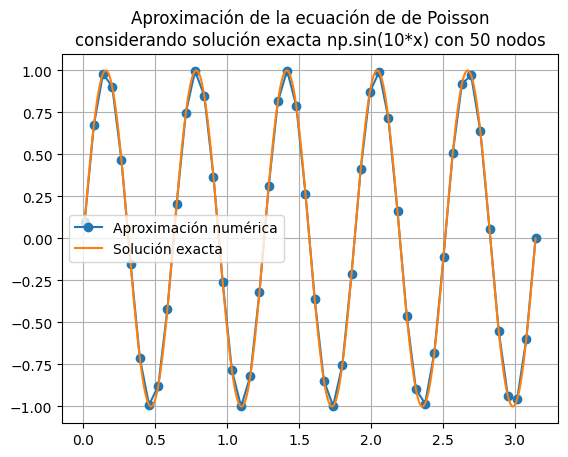

In [153]:
import inspect

# Testeo solver 1
a = .01                                 # Extremo derecho intervalo
b = np.pi                               # Extremo derecho intervalo
u_ex = lambda x: np.sin(10*x)           # Solución exacta
f = lambda x: 100*np.sin(10*x)          # Lado derecho
x = np.linspace(a, b,50)                # Partición del intervalo

plot_poisson(x, f, u_ex, 3)

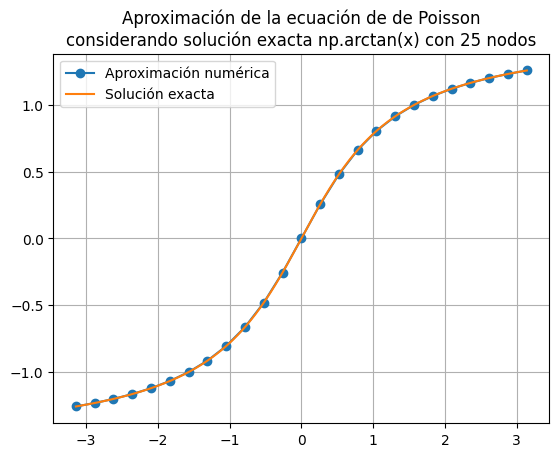

In [156]:
# Testeo solver 2
a = -np.pi                              # Extremo derecho intervalo
b = np.pi                               # Extremo derecho intervalo
u_ex = lambda x: np.arctan(x)           # Solución exacta
f = lambda x: 2*x/(x**2+1)**2           # Lado derecho (-u_ex'')
x = np.linspace(a, b,25)                # Partición del intervalo

plot_poisson(x, f, u_ex, 3)

## Refinamiento adaptativo

En el estudio de los métodos númericos para ecuaciones diferenciales es crucial el manejo del error a priori y a posterior de la aproximación de las soluciones. En el marco de este último, interesa controlar la discrepancia entre la solución apróximada ya calculada y la solución real, así bajo ciertas suposiciones en el planteamiento del problema discreto es posible adaptar la malla en los elementos de la partición donde el error es más considerable (ver [aquí](https://en.wikipedia.org/wiki/Adaptive_mesh_refinement)). Un módelo simplificado para nuestro caso sería considerar la discrepancia de las derivadas en cada nodo interior, los cuales se denominan saltos de derivadas y se definen por:
$$J_i\,:=\,\vert u_h^-(x_i^-) \,-\,  u_h^+(x_i^+)\vert\qquad \forall i\in\{1,...,n-1\}$$
El análisis de estos permite iterar la resolución del problema luego de cada resolución para ajustar la malla en pos de obtener una mejor aproximación en donde se detecta que la solución discreta no es tan suave como dicta la teoría.

In [166]:
def jumps(x, u):
    """
    Cálculo de los saltos de las derivadas en u en cada nodo interiro de la
    partición x en base a que u es un elemento de de las funciones continuas
    tales que en cada elemento es un polinomio de grado 1.

    Input:
    x (list[int]): Partición
    u (list[int]): Vector coordenada de u en la base de P_h

    Return
    list[int]: Saltos de las derivadas de u en los nodos interiores de x
    """
    js = [
        abs(
            (u[i] - u[i - 1])/(x[i]-x[i-1]) -
            (u[i+1] - u[i])/(x[i+1]-x[i]))
        for i in range(1, len(x)-1)
    ]
    return js

def amr(x, u, tol):
    """
    Refinamiento adaptativo de la malla x en base a los saltos de las derivadas
    de u con una tolerancia dada.

    Input:
    x (list[int]): Partición
    u (list[int]): Vector coordenada de u en la base de P_h
    tol (float): Tolerancia para los saltos de derivadas

    Return
    (list[int]): Partición luego del refinamiento adaptativo
    """
    js = jumps(x, u)
    for i, j in enumerate(js):
        if j > tol:
            x = np.concatenate((x, np.array([.5*(x[i]+x[i+1])])))
    if len(x) != len(u):
        x = np.concatenate((x, np.array([.5*(x[len(js)]+x[len(js)+1])])))
    return np.sort(x)

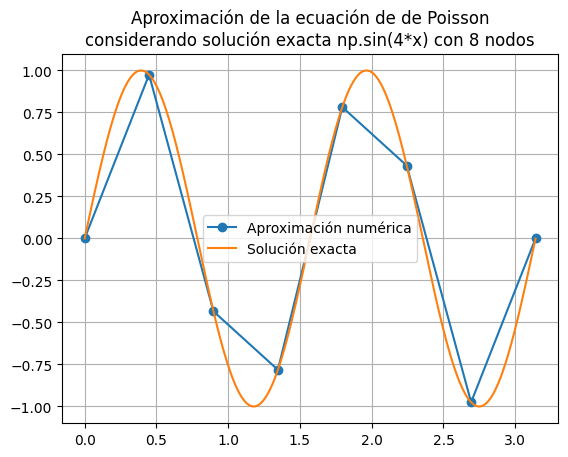

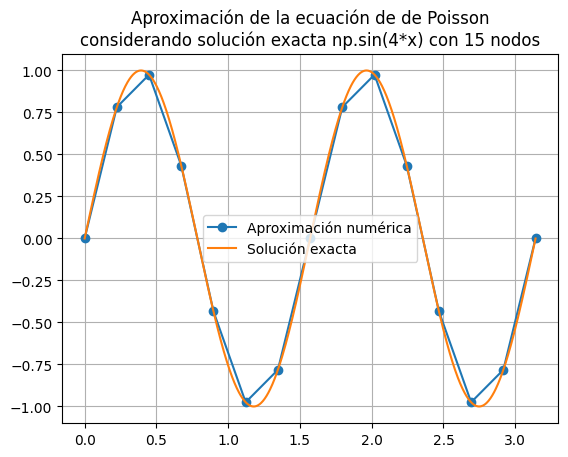

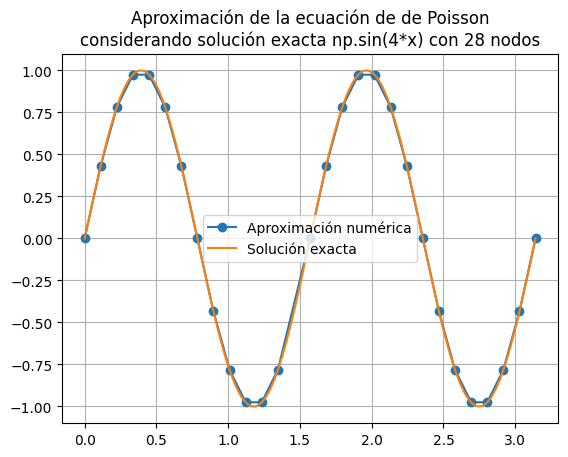

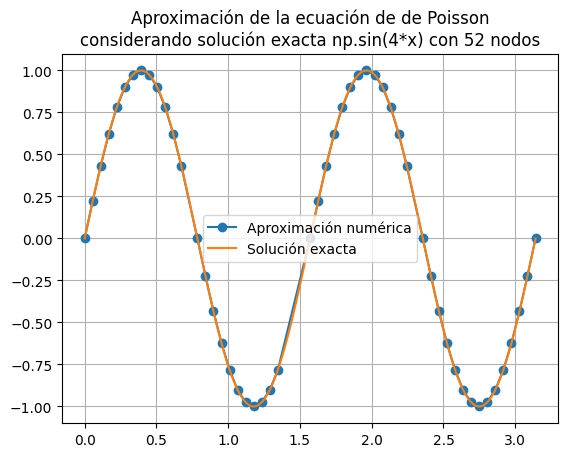

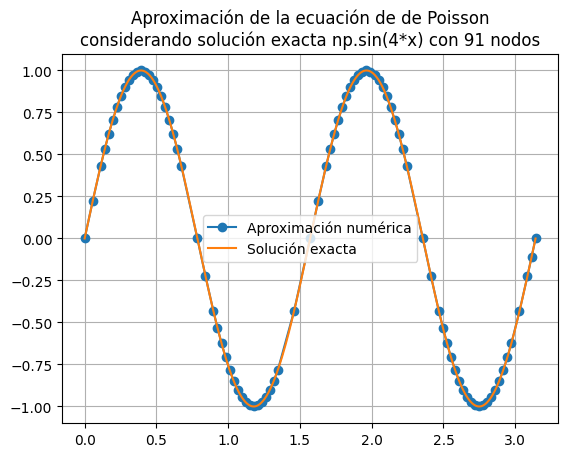

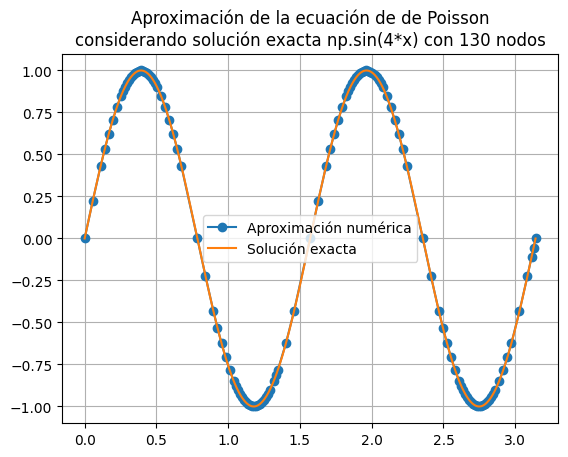

In [173]:
# Testeo solver adaptativo 1
a = 0                                # Extremo derecho intervalo
b = np.pi                            # Extremo derecho intervalo
u_ex = lambda x: np.sin(4*x)         # Solución exacta
f = lambda x: 16*np.sin(4*x)         # Lado derecho
x = np.linspace(a, b,8)              # Partición del intervalo
tol = .4                             # Tolerancia para el amr

# Resolución iterativa del PVC
for i in range(10):

    # Resolución del PVC
    x, u = plot_poisson(x, f, u_ex, 3)

    # Refinamiento adaptativo
    x = amr(x, u, tol)

    # Algún críterio de detención de la iteración
    if abs(len(x)-len(u)) < len(u)/3:
        break

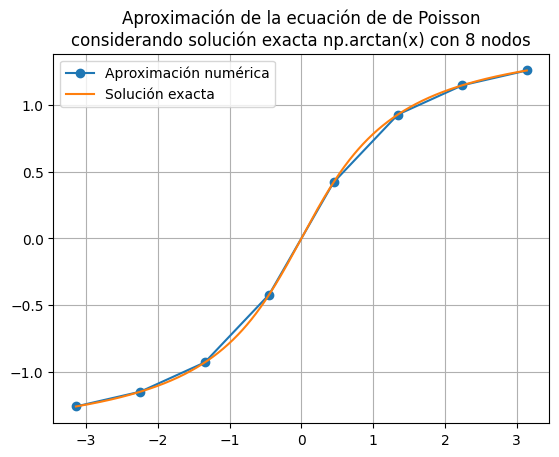

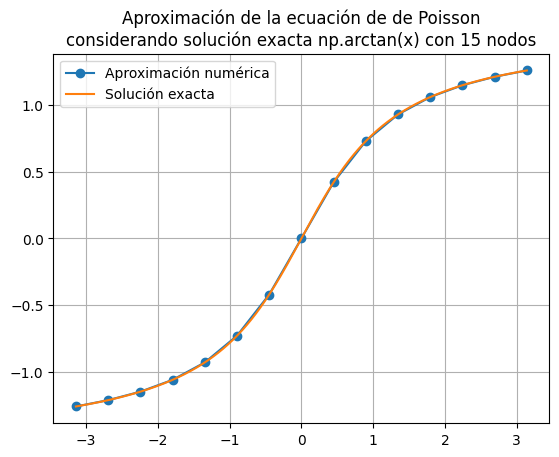

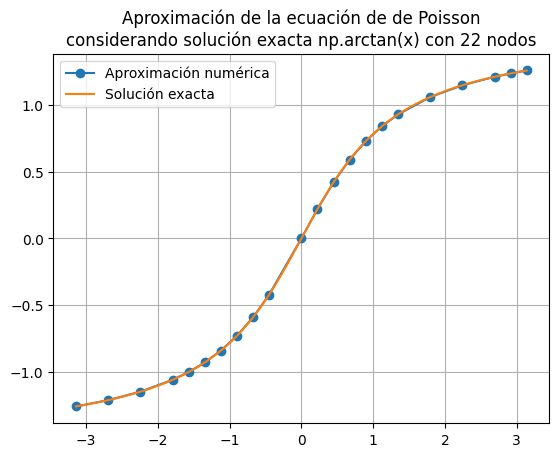

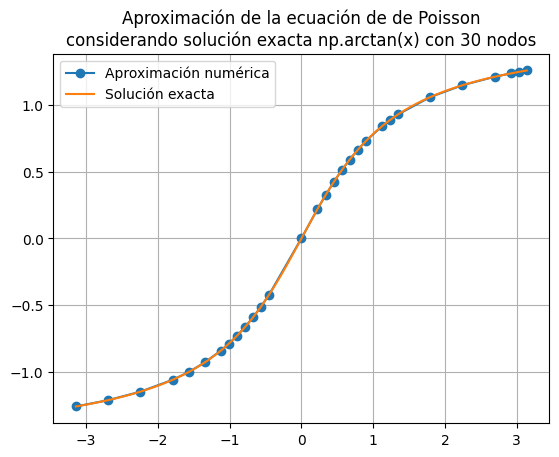

In [172]:
# Testeo solver adaptativo 2
a = -np.pi                              # Extremo derecho intervalo
b = np.pi                               # Extremo derecho intervalo
u_ex = lambda x: np.arctan(x)           # Solución exacta
f = lambda x: 2*x/(x**2+1)**2           # Lado derecho (-u_ex'')
x = np.linspace(a, b,8)                 # Partición del intervalo
tol = .1                                # Tolerancia para el amr

# Resolución iterativa del PVC
for i in range(10):

    # Resolución del PVC
    x, u = plot_poisson(x, f, u_ex, 3)

    # Refinamiento adaptativo
    x = amr(x, u, tol)

    # Algún críterio de detención de la iteración
    if abs(len(x)-len(u)) < len(u)/3:
        break